## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split

%matplotlib inline

## Feature Extraction

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Gives HoG feature vector back given an image
    :param img: Any input image 
    :param orient: Number of orientations in which HoG gradients need to be taken in
    :param pix_per_cell: Number of pixes per cell
    :param cell_per_block: Number of cells per block
    :param vis: If true, HoG image is returned
    :param feature_vec: If true, feature vector is returned
    :return: HoG feature vectors along with visualization image
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def bin_spatial(img, size=(32, 32)):
    """
    Returns spatial features for a given image by converting them to specific size and raveling the feature vector
    :param img: Any given image
    :param size: Size the image needs to be scaled to
    :return: Feature vector
    """
    features = cv2.resize(img, size).ravel()
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Returns vectors for histograms of each channel separately compiled into `nbins` with the `bins_range` specified
    :param img: Any given image
    :param nbins: Number of bins into which the histogram needs to be compiled into
    :param bins_range: The range between which the histogram needs to be compiled into
    :return: Feature vector for color histogram
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract required features from a given dataset and returns feature vectors for all the images.
    :param imgs: Filenames of all images that need feature extraction
    :param color_space: Color space in which feature extraction needs to be done. Supported values are RGB, HSV, HLS,
    LUV, YUV, YCrCb
    :param spatial_size: Image resizing size for extracting spatial feature vector
    :param hist_bins: Number of bins for extracting color histogram
    :param orient: Number of orientations in which history of gradients needs to be evaluated in
    :param pix_per_cell: Number of pixels per cell that needs to be taken for evaluating HoG
    :param cell_per_block: Number of cells per block for evaluating HoG
    :param hog_channel: The channel of image in which HoG vectors needs to be extracted from. Supported values are 0, 1,
    2 and ALL
    :param spatial_feat: If True, spatial features are extracted
    :param hist_feat:  If True, histogram features are extracted
    :param hog_feat: If True, HoG features are extracted
    :return: Feature vectors for all images in a given dataset
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0,1))
            file_features.append(hist_features)
        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """    
    :param img: Any image 
    :param color_space: Color space in which feature extraction needs to be done. Supported values are RGB, HSV, HLS,
    LUV, YUV, YCrCb
    :param spatial_size: Image resizing size for extracting spatial feature vector
    :param hist_bins: Number of bins for extracting color histogram
    :param orient: Number of orientations in which history of gradients needs to be evaluated in
    :param pix_per_cell: Number of pixels per cell that needs to be taken for evaluating HoG
    :param cell_per_block: Number of cells per block for evaluating HoG
    :param hog_channel: The channel of image in which HoG vectors needs to be extracted from. Supported values are 0, 1,
    2 and ALL
    :param spatial_feat: If True, spatial features are extracted
    :param hist_feat:  If True, histogram features are extracted
    :param hog_feat: If True, HoG features are extracted
    :return: Feature vectors for a given image 
    """
    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)      
    
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0,1))
        img_features.append(hist_features)
    
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        img_features.append(hog_features)

    return np.concatenate(img_features)

## Sliding Windows

In [6]:
def slide_window(img, x_start_stop=None, y_start_stop=None,
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Returns a list of windows by sliding over the image between given X and Y start stop values
    :param img: Any given image
    :param x_start_stop: The start and stop values for X co-ordinate. If None, image dimensions are taken
    :param y_start_stop: The start and stop values for Y co-ordinate. If None, image dimensions are taken
    :param xy_window: Size of window in XY plane
    :param xy_overlap: The overlap between two windows
    :return: A list of windows over the image
    """

    if y_start_stop is None:
        y_start_stop = [None, None]
    if x_start_stop is None:
        x_start_stop = [None, None]

    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Getting all windows

In [7]:
def get_all_windows(im):
    """
    Returns all windows over a given image. We use smaller windows at the center of image and bigger at the end of the lane
    :param im: Any given image
    :return: Returns all windows after sliding over the image
    """
    image = mpimg.imread(im)
    all_windows = []

    y = 380
    window_sizes = [(64,64), (128, 128), (192, 192), (256, 256)]
    Y_start_stop = [[y,y+2*64],[y,y+2*128],[y,y+192],[y,y+256]]
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=Y_start_stop[i], 
                            xy_window=window_sizes[i], xy_overlap=(0.75,0.75))
        all_windows.extend(windows)

    return all_windows

## Searching and drawing boxes

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Given an image and windows, overlays the boxes over the images
    :param img: Any given image
    :param bboxes: Windows which needs to be drawn
    :param color: Color of the box
    :param thick: Thickness of the box
    :return: Returns an image with boxes overlaid.
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    """
    Goes through windows of given image and figures out if a car is present in it or not using the classifier supplied.
    If car is present, that window will be appended to return list.
    :param img: Any given image that needs to be searched for cars
    :param windows: All possible windows
    :param clf: Classifier used. SVM
    :param scaler: StandardScalar to normalize the feature vectors
    :param color_space: The color space in which the feature extraction needs to happen
    :param spatial_size: Size of the image to be rescaled to, for extracting spatial features
    :param hist_bins: Number of bins in histogram for extract color histogram features
    :param hist_range: Range of histograms for color histogram
    :param orient: Number of orientations in HoG extraction
    :param pix_per_cell: Number of pixels per cell for HoG extraction
    :param cell_per_block: Number of cells per block in extracting HoG features
    :param hog_channel: Channels in which HoG vectors need to be extracted
    :param spatial_feat: If True, will extract spatial feature vectors
    :param hist_feat: If True, will extract histogram feature vectors
    :param hog_feat: If true, will extract HoG feature vectors
    :return: All windows where car is likely to be present
    """
    on_windows = []
    for window in windows:

        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      

        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)
    return on_windows


def add_heat(heatmap, bbox_list):
    """
    Adds `heat` for all pixels in a given window. More heat implies that same pixel was in more windows
    implying more likeliness of that being a correct classification
    :param heatmap: Image that needs to be applied heatmap upon
    :param bbox_list: List of boxes that were detected
    :return: Returns a heatmap image
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    """
    Applies a threshold on the pixels. If a particular pixel intensity is less than the threshold, it is set to 0
    :param heatmap: Image that needs to be thresholded
    :param threshold: Threshold value itself
    :return: Image with threshold optimized
    """
    # Zero out pixels below the threshold
    threshold_image = heatmap.copy()
    threshold_image[threshold_image <= threshold] = 0
    # Return thresholded map
    return threshold_image


def draw_labeled_bboxes(img, labels):
    """
    Draws windows over the labels that are provided on a given image
    :param img: Any given image
    :param labels: Contains positions of the windows where a rectangle needs to be drawn
    :return: An image with labeled windows drawn upon
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Reading in labelled data

In [10]:
# Read in cars and notcars
import random

images = glob.glob('./data/*.png')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# This is to get equal number of car and notcar images.
k = random.sample(range(0, len(notcars)), len(cars))
notcars = [notcars[i] for i in k]

## Variable initialization

In [11]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 720] # Min and max in y to search in slide_window()

## Extracting features from labeled data

In [12]:
print("Extracting car features")
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Extracting not-car features")
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("Completed extracting features")

Extracting car features
Extracting not-car features
Completed extracting features


## Training classifier

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
4.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9946


In [14]:
pred = svc.predict(X_test)
ne = (y_test - pred).nonzero()[0]
print(ne.shape)
print(len(X_test))

(13,)
2387


## Class for keeping track of previous frames

In [15]:
from collections import deque


class HotBoxes:
    def __init__(self, s=5):
        self.previous_frame_boxes = deque([], maxlen=s)
    
    def add_boxes(self, boxes):
        self.previous_frame_boxes.append(boxes)
        
    def get_boxes(self):
        boxes = []
        for box in self.previous_frame_boxes:
            boxes.extend(box)
        return boxes

## Process pipeline

In [18]:
hot_boxes = HotBoxes(s=24)
all_windows = get_all_windows('test.jpg')


def process_pipeline(img):        
    draw_image = np.copy(img)
    
    img = img.astype(np.float32)/255
    
    hot_windows = search_windows(img, all_windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    hot_boxes.add_boxes(hot_windows)
    
    hot_image = np.zeros_like(img[:,:,0]).astype(np.float)
    heated_img = add_heat(hot_image, hot_boxes.get_boxes())                   

    threshold_heat_image = apply_threshold(heated_img, 36)
    
    labels = label(threshold_heat_image)
    final_image = draw_labeled_bboxes(draw_image, labels)
    return final_image

### Testing on single image

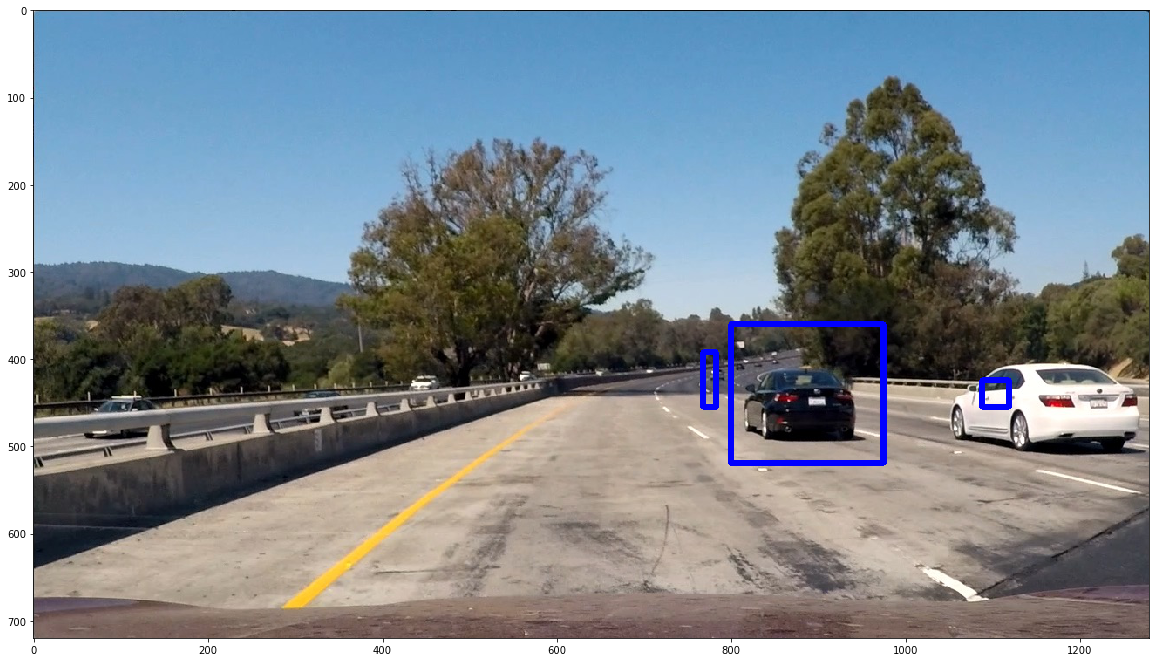

In [17]:
plt.figure(figsize=(20,20))
img = mpimg.imread('test.jpg')
final_image = process_pipeline(img)
plt.imshow(final_image)

### Creating video

In [19]:
from moviepy.editor import VideoFileClip


def create_video(input_file, output_file):
    input_clip = VideoFileClip(input_file)
    output_clip = input_clip.fl_image(process_pipeline)
    output_clip.write_videofile(output_file, audio=False)

In [20]:
create_video('project_video.mp4', 'final-run-24-frames.mp4')

[MoviePy] >>>> Building video final-run-24-frames.mp4
[MoviePy] Writing video final-run-24-frames.mp4


100%|█████████▉| 1260/1261 [1:01:29<00:02,  2.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final-run-24-frames.mp4 



# Images for writeup

In [ ]:
car_o = mpimg.imread(notcars[24])
car1 = cv2.cvtColor(car_o, cv2.COLOR_RGB2HSV)

plt.figure(figsize=(10,10))
plt.subplot(141)
plt.title("original")
plt.imshow(car_o)
plt.axis('off')

channel = ['H', 'S', 'V']

for i in range(0,3):
    hog_features_car, hog_car_image = get_hog_features(car1[:,:,i], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    ind = 142+i
    plt.subplot(ind)
    plt.title("hog - channel {}".format(channel[i]))
    plt.imshow(hog_car_image, cmap='gray')
    plt.axis('off')

plt.figure(figsize=(10,10))
plt.subplot(141)
plt.title("original")
plt.imshow(car_o)
plt.axis('off')


for i in range(0,3):
    ind = 142+i
    plt.subplot(ind)
    plt.title("channel - {}".format(channel[i]))
    plt.imshow(car_o[:,:,i], cmap='gray')
    plt.axis('off')

# plt.imshow(hog_car_image, cmap='gray')

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title("Car")
plt.imshow(mpimg.imread(cars[24]))
plt.axis('off')
plt.subplot(122)
plt.title("Not-Car")
plt.imshow(mpimg.imread(notcars[24]))
plt.axis('off')

In [ ]:
print(len(cars))
print(len(notcars))

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(mpimg.imread('test6.jpg'))